In [1]:
import sys
sys.path.append('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/')

In [2]:
import os 
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Hyperparam_Testing.Testing_Notebooks.Common_Functions as cf 
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import models 

from keras.regularizers import l2
from Hyperparam_Testing.Testing_Notebooks import chirallag as cL

import matplotlib
matplotlib.rcParams.update({'legend.fontsize': 16})
matplotlib.rcParams.update({'font.size': 16})

In [16]:
## Generate fields 
data = cf.gen_and_load(2*10**5,10**5)

In [17]:
#Hold out Validation
train_x, train_y = data[0]
val_x,val_y = data[1] 
print(train_x.shape,val_x.shape)

(100000, 16) (100000, 16)


In [18]:
noise_std = np.logspace(-4,-1,10)
noisy_xs_train = []
noisy_xs_val = []
for i in noise_std:
    noisy_xs_train.append(cf.apply_noise(train_x,i))
    noisy_xs_val.append(cf.apply_noise(train_x,i))

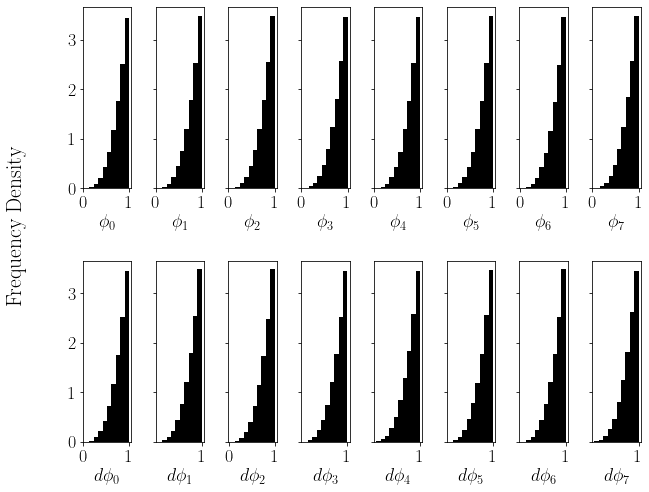

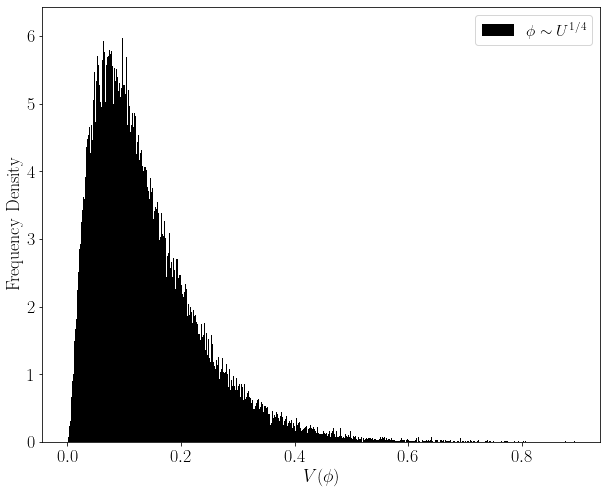

In [19]:
#Sense check fields
cf.field_plotter(noisy_xs_train[0],train_y)

In [20]:
opt = keras.optimizers.Adam(amsgrad= True, beta_1= 0.9, beta_2=0.98)

In [21]:
def noise_test(noise_std,repeats):
    no_noise_std = len(noise_std)
    is_last_val_bool = np.zeros(no_noise_std)
    min_mape = np.zeros((no_noise_std,repeats))
    ii = 0
    fig ,ax = plt.subplots(1)
    for ii,i in enumerate(noise_std):   
        print('noise with sigma = ',i)
        last_val_bool = 0
        for j in range(repeats):
            
            ### Training 
            x_train = cf.apply_noise(train_x,i)
            x_val = cf.apply_noise(val_x,i)
            df = pd.DataFrame(cf.trained_network(x_train,train_y,x_val,val_y,np.ones(5)*300, optimizer= opt , verbose= 0,epochs = 100, batch_size= 32,initializer= 'random_normal').history)
            val_mape_ar_smoothed = cf.exponetial_smoothing(np.array(df['val_mean_absolute_percentage_error']),0.4)
            loss_ar_smoothed = cf.exponetial_smoothing(np.array(df['loss']),0.4)
            min_mape[ii,j] = np.min(val_mape_ar_smoothed)
            
            
            



            ### Negative Grad
            if cf.neg_grad_tester(val_mape_ar_smoothed,loss_ar_smoothed):
                last_val_bool +=1
                print('Negative Grad Identified')
            else:
                pass
        if last_val_bool >= repeats/4:
            is_last_val_bool[ii] = 1
        else:
            is_last_val_bool[ii] = 0
        ###Plotting each training cycle
        epoch_num = len(df['val_mean_absolute_percentage_error'])
        epochs = np.arange(1,epoch_num+1)
        ax.plot(epochs,loss_ar_smoothed, color = 'black',label = 'Smoothed  MAPE ')
        ax.plot(epochs,val_mape_ar_smoothed, color = 'red',label = 'Smoothed Validation MAPE')
        ax.set_xlabel('Training Epochs')
        ax.set_ylabel('Mean Minimum MAPE')
        ax.set_ylim(0,20)
        ax.set_title('$\sigma ={{{}}}$'.format(i))
        plt.show()
    path = '/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Guassian_Noise/Training_Data'
    file_name = 'Guassian_noise'+str(noise_std[0])+'-'+str(noise_std[-1]) 
    np.savetxt(os.path.join(path,file_name+'mape_{}.csv'.format(103)),min_mape,delimiter=',')
    np.savetxt(os.path.join(path,file_name+'bool_{}.csv'.format(103)),is_last_val_bool,delimiter=',')
    return min_mape, is_last_val_bool

noise with sigma =  0.0001
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified


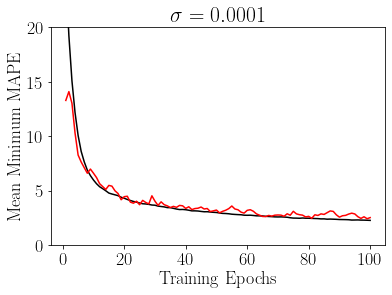

noise with sigma =  0.00021544346900318845
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
noise with sigma =  0.00046415888336127773
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
noise with sigma =  0.001
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
noise with sigma =  0.002154434690031882
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
Negative Grad Identified
noise with sigma =  0.004641588833612777
Negative Grad Identified
noise with sigma =  0.01
noise with sigma =  0.021544346900318822
Negative Grad Identified
noise with sigma =  0.046415888336127774
noise with sigma =  0.1


In [22]:
min_mape ,bool = noise_test(noise_std, 10)

In [23]:
def load_data(noise_std, path):
    file_ext = 'Guassian_noise'+str(noise_std[0])+'-'+str(noise_std[-1])
    min_mape = np.loadtxt(os.path.join(path,file_ext+'mape.csv'),delimiter = ',')
    bools = np.loadtxt(os.path.join(path,file_ext+'bool.csv'),delimiter=',')
    return min_mape, bools

In [24]:
path = '/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Guassian_Noise/Training_Data'
min_mape , bools = load_data(noise_std, path)
print(min_mape[-1])

[44.00588179 42.55707334 44.2361748  44.41237826 43.35233272 44.29173138
 41.64977486 42.42461549 41.94457012 42.86985393]


In [25]:
mean_min_mape  =  np.mean(min_mape,axis = 1)
ste_min_mape = np.std(min_mape,axis = 1)/np.sqrt(min_mape.shape[1]) 

In [26]:
###Analytic Noise Scaling
def V_eval(train_x):
    pi = train_x[:,:8]
    dpi = train_x[:,8:]
    gens = cL.gen_gellman(3)
    F0 = 1
    orig_V = cL.get_V(pi,dpi,gens,F0).real
    return orig_V
analytic_MAPE =[]
for i in noisy_xs_train:
    analtic_V = abs(V_eval(i))
    analytic_MAPE.append(np.mean(abs((analtic_V - train_y)/train_y)*100)) 

In [27]:
np.savetxt('./Training_Data/analytic_mape_new_bounds_10_5.csv',analytic_MAPE,delimiter=',')

#print(V_eval(noisy_xs_train[1])-train_y)

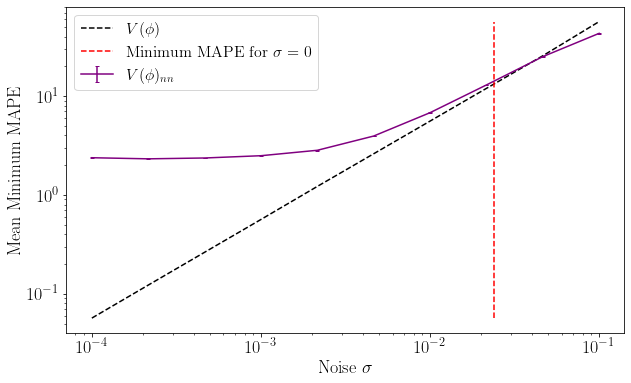

In [28]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 18
fig, ax  = plt.subplots(1, figsize = (10,6))
ax.errorbar(noise_std,mean_min_mape,ste_min_mape, color ='Purple',capsize= 2,label = r'$V(\phi)_{nn}$')
ax.plot(noise_std,analytic_MAPE,linestyle = '--', color = 'Black', label ='$V(\phi)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Noise $\sigma$')
ax.set_ylabel('Mean Minimum MAPE')
ax.plot(np.ones_like(noise_std)*mean_min_mape[0]/100,analytic_MAPE, c = 'red', linestyle = '--',label = 'Minimum MAPE for $\sigma = 0$')
ax.set_ylim()
ax.legend()
fig.savefig('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Figures/Guassian_Noise_Scaling.png',dpi =300,transparent=False)